# Pregunta 2. Análisis de opiniones sobre películas.
a) En primer lugar hay que descargar los datos de la URL asignada y luego se guardan en los archivos train_data2.csv y test_data2.csv. 

Luego se abren los archivos y se crea un dataframe para los conjuntos de datos de entrenamiento (train) y prueba (test).

La primera columna de los sets de datos corresponde al sentimiento (Sentiment). Si es "-1", entonces el comentario es negativo. Si es "+1" entonces el comentario será positivo. Esto se pudo comprobar leyendo un extracto del dataframe. 

La segunda columna será el review de la persona con respecto a una película.

In [20]:
import urllib
import pandas as pd

'''
train_data_url = "http://www.inf.utfsm.cl/~jnancu/stanford-subset/polarity.train"
test_data_url = "http://www.inf.utfsm.cl/~jnancu/stanford-subset/polarity.dev"
train_data_f = urllib.urlretrieve(train_data_url, "train_data2.csv")
test_data_f = urllib.urlretrieve(test_data_url, "test_data2.csv")
'''


ftr = open("train_data2.csv", "r")
fts = open("test_data2.csv", "r")
rows = [line.split(" ",1) for line in ftr.readlines()]
train_df = pd.DataFrame(rows, columns=['Sentiment','Text'])
train_df['Sentiment'] = pd.to_numeric(train_df['Sentiment'])
rows = [line.split(" ",1) for line in fts.readlines()]
test_df = pd.DataFrame(rows, columns=['Sentiment','Text'])
test_df['Sentiment'] = pd.to_numeric(test_df['Sentiment'])
print train_df.shape
print test_df.shape

(3554, 2)
(3554, 2)


Finalmente, se tiene que tanto el conjunto de entrenamiento como el de pruebas tienen igual cantidad de registros (3554 filas).

b) Ahora hay que crear una función que entregue una lista de palabras a partir de un determinado texto. A continuación se muestra el código del enunciado, en el cual realiza lematización. Notar que la función ya incluye su debida transformación a lower-case.

In [21]:
import re, time
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer, word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer

def word_extractor_lemmatizer(text, del_stopwords=True):
    wordlemmatizer = WordNetLemmatizer()
    if del_stopwords == True:
        commonwords = stopwords.words('english')
    text = re.sub(r'([a-z])\1+', r'\1\1',text)#substitute multiple letter by two
    words = ""
    wordtokens = [ wordlemmatizer.lemmatize(word.lower()) for word in word_tokenize(text.decode('utf-8', 'ignore')) ]
    for word in wordtokens:
        if del_stopwords==True:
            if word not in commonwords:
                words+=" "+word
        else:
            words+=" "+word
    return words

print word_extractor_lemmatizer("I love to eat cake")
print word_extractor_lemmatizer("I love eating cake")
print word_extractor_lemmatizer("I loved eating the cake")
print word_extractor_lemmatizer("I do not love eating cake")
print word_extractor_lemmatizer("I don't love eating cake")

 love eat cake
 love eating cake
 loved eating cake
 love eating cake
 n't love eating cake


El siguiente código es el modificado que incluye el proceso de stemming.

In [22]:
def word_extractor(text, del_stopwords=True):
    stemmer = PorterStemmer()
    if del_stopwords==True:
        commonwords = stopwords.words('english')
    text = re.sub(r'([a-z])\1+', r'\1\1',text)#substitute multiple letter by two
    words = ""
    wordtokens = [ stemmer.stem(word.lower()) for word in word_tokenize(text.decode('utf-8', 'ignore')) ]
    for word in wordtokens:
        if del_stopwords==True:
            if word not in commonwords:
                words+=" "+word
        else:
            words+=" "+word
    return words

print word_extractor("I love to eat cake")
print word_extractor("I love eating cake")
print word_extractor("I loved eating the cake")
print word_extractor("I do not love eating cake")
print word_extractor("I don't love eating cake")

 love eat cake
 love eat cake
 love eat cake
 love eat cake
 n't love eat cake


Se observa una gran diferencia ya que, para la función que incluye lematización, se puede ver a simple vista que solo se eliminaron las stop-words. En cambio, para la función con stemming, las primeras cuatro frases quedan como "love eat cake", ya que las palabras "loved" y "eating" se redujeron a su raiz "love" y "eat" respectivamente.

Probando con otras frases...

In [4]:
print word_extractor("I'm playing PlayStation 4 every week")
print word_extractor("I play PlayStation 4 every week")

print word_extractor("I learned a lot in the Machine Learning class")
print word_extractor("I learn a lot from the Machine Learning classes")


 'm play playstat 4 everi week
 play playstat 4 everi week
 learn lot machin learn class
 learn lot machin learn class


En los ejemplos anteriores, se ve que para las dos primeras frases la función trata al nombre propio "PlayStation" como una palabra más, y le borra el sufijo "ion", quedando "playstat". 

Para las otras dos frases, cada una entrega un mensaje distinto. La primera comunica que el sujeto aprendió harto de la clase de Machine Learning. En la segunda frase, el sujeto informa que aprende harto de las clases de Machine Learning. Aún así, luego del proceso de stemming ambas frases quedan iguales.

c) La función word_extractor_lemmatizer() trata las palabras por lematización y fue realizada anteriormente. A continuación se muestran los últimos ejemplos anteriores utilizando lematización.

In [5]:
print word_extractor_lemmatizer("I'm playing PlayStation 4 every week")
print word_extractor_lemmatizer("I play PlayStation 4 every week")

print word_extractor_lemmatizer("I learned a lot in the Machine Learning class")
print word_extractor_lemmatizer("I learn a lot from the Machine Learning classes")

 'm playing playstation 4 every week
 play playstation 4 every week
 learned lot machine learning class
 learn lot machine learning class


Técnicamente, el proceso de stemming lo que hace es cortar el final de las palabras sin importar el significado de la palabra según el contexto. Lemmatization (o lematización) es un proceso mas complejo, ya que utiliza una búsqueda en un vocabulario y realiza un análisis morfológico de las palabras.

d) Ahora hay que realizar una representación vectorial de los textos de entrenamiento y pruebas. En primer lugar, los textos se pasan por el proceso de lematización, eliminando también las *stop words*. Luego, se inicializa la función *CountVectorizer* con n=1, de tal forma que cada palabra sumará 1. Esto es útil cuando se suma el total de la presencia de una palabra. Estos vectores quedan guardados en *features_train* y *features_test* para los sets de entrenamiento y prueba respectivamente.

Luego se guarda la etiqueta de cada review. Cuando el campo Sentiment es -1 y se suma con 1, queda en 0. Si el mismo campo es 1 y se suma con 1, luego se divide por 2 y queda 1. Entonces, las etiquetas quedarán guardadas como 0 cuando la review es negativa y 1 cuando la review es positiva. Estos datos quedan guardados en las variables *labels_train* y *labels_test*.

Luego se guardan las palabras en el vector *vocab*, y su frecuencia de aparición en el vector *dist*. Esto es usado más abajo para determinar cuáles son las palabras mas frecuentes tanto en el set de entrenamiento como en el de prueba.

In [23]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
def vectorial(modo='lemmatization', del_stopwords=True, print_top10=0):
    
    if modo=='lemmatization':
        if del_stopwords==True:
            texts_train = [word_extractor_lemmatizer(text) for text in train_df.Text]
            texts_test = [word_extractor_lemmatizer(text) for text in test_df.Text]
        else:
            texts_train = [word_extractor_lemmatizer(text, False) for text in train_df.Text]
            texts_test = [word_extractor_lemmatizer(text, False) for text in test_df.Text]
    if modo == 'stemming':
        if del_stopwords==True:
            texts_train = [word_extractor(text) for text in train_df.Text]
            texts_test = [word_extractor(text) for text in test_df.Text]
        else:
            texts_train = [word_extractor(text, False) for text in train_df.Text]
            texts_test = [word_extractor(text, False) for text in test_df.Text]

    vectorizer = CountVectorizer(ngram_range=(1, 1), binary='False')
    vectorizer.fit(np.asarray(texts_train))
    features_train = vectorizer.transform(texts_train)
    features_test = vectorizer.transform(texts_test)
    labels_train = np.asarray((train_df.Sentiment.astype(float)+1)/2.0)
    labels_test = np.asarray((test_df.Sentiment.astype(float)+1)/2.0)

    vocab = vectorizer.get_feature_names()
    dist_train=list(np.array(features_train.sum(axis=0)).reshape(-1,))
    if print_top10 == 1:
        rank = []
        for tag, count in zip(vocab, dist_train):
            rank.append((count, tag))

        rank.sort()
        rank[:] = rank[::-1]
        
        print "MODO:", modo, "ELIMINA stopwords:", del_stopwords, "\n"
        
        print "Palabras más frecuentes en el set de entrenamiento"
        for i in range(0,10):
            print "Frecuencia: %d, palabra: %s"% (rank[i][0], rank[i][1])

        vocab = vectorizer.get_feature_names()
        dist_test=list(np.array(features_test.sum(axis=0)).reshape(-1,))

        rank = []
        for tag, count in zip(vocab, dist_test):
            rank.append((count, tag))

        rank.sort()
        rank[:] = rank[::-1]
        print "\nPalabras más frecuentes en el set de prueba"
        for i in range(0,10):
            print "Frecuencia: %d, palabra: %s"% (rank[i][0], rank[i][1])
    return features_train, labels_train, features_test, labels_test

In [46]:
vectorial(print_top10=1)

MODO: lematize ELIMINA stopwords: True 

Palabras más frecuentes en el set de entrenamiento
Frecuencia: 566, palabra: film
Frecuencia: 481, palabra: movie
Frecuencia: 246, palabra: one
Frecuencia: 245, palabra: like
Frecuencia: 224, palabra: ha
Frecuencia: 183, palabra: make
Frecuencia: 176, palabra: story
Frecuencia: 163, palabra: character
Frecuencia: 145, palabra: comedy
Frecuencia: 143, palabra: time

Palabras más frecuentes en el set de prueba
Frecuencia: 558, palabra: film
Frecuencia: 540, palabra: movie
Frecuencia: 250, palabra: one
Frecuencia: 238, palabra: ha
Frecuencia: 230, palabra: like
Frecuencia: 197, palabra: story
Frecuencia: 175, palabra: character
Frecuencia: 165, palabra: time
Frecuencia: 161, palabra: make
Frecuencia: 134, palabra: comedy


e) La función *classification_report* de *sklearn* retorna precision, recall y F1 score. Estos indicadores se definen como siguen:
* precision: Cantidad de verdaderos positivos dividido por la cantidad de resultados positivos obtenidos (falsos y verdaderos juntos).
* recall: Cantidad de verdaderos positivos obtenidos dividido por la cantidad de positivos que se deberían haber obtenido.
* F1 score: Corresponde a la media armónica entre precision y recall. Se calcula de la siguiente forma: $F1 Score = 2\frac{precision * recall}{precison + recall}$

In [24]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

scores_NAIVE = np.zeros(5)
scores_MULTI = np.zeros(5)
scores_LOGIT = np.zeros(5)
scores_SVM = np.zeros(5)

def score_the_model(model,x,y,xt,yt,text):
    acc_tr = model.score(x,y)
    acc_test = model.score(xt[:-1],yt[:-1])
    print "Training Accuracy %s: %f"%(text,acc_tr)
    print "Test Accuracy %s: %f"%(text,acc_test)
    print "Detailed Analysis Testing Results ..."
    print(classification_report(yt, model.predict(xt), target_names=['+','-']))
    
    precision, recall, fscore, support = precision_recall_fscore_support(yt, model.predict(xt))
    if text == 'BernoulliNB':
        scores_NAIVE[0] = acc_tr
        scores_NAIVE[1] = acc_test
        scores_NAIVE[2] = np.mean(precision)
        scores_NAIVE[3] = np.mean(recall)
        scores_NAIVE[4] = np.mean(fscore)
    elif text == 'MultinomialNB':
        scores_MULTI[0] = acc_tr
        scores_MULTI[1] = acc_test
        scores_MULTI[2] = np.mean(precision)
        scores_MULTI[3] = np.mean(recall)
        scores_MULTI[4] = np.mean(fscore)
    elif text == 'LOGISTIC':
        scores_LOGIT[0] = acc_tr
        scores_LOGIT[1] = acc_test
        scores_LOGIT[2] = np.mean(precision)
        scores_LOGIT[3] = np.mean(recall)
        scores_LOGIT[4] = np.mean(fscore)
    elif text == 'SVM':
        scores_SVM[0] = acc_tr
        scores_SVM[1] = acc_test
        scores_SVM[2] = np.mean(precision)
        scores_SVM[3] = np.mean(recall)
        scores_SVM[4] = np.mean(fscore)

f) A continuación se muestra el código que realiza el modelo con el algoritmo **Bernoulli naive Bayes** (binario). Se ejecuta la función *vectorial(modo=..., del_stopwords=..., print_top10=...)* de forma que el retorno de la función cargue los datos de features y labels según el tipo de filtro de palabras que se quiera ocupar.

In [25]:
from sklearn.naive_bayes import BernoulliNB
import random

def do_NAIVE_BAYES(x,y,xt,yt):
    model = BernoulliNB()
    model = model.fit(x, y)
    score_the_model(model,x,y,xt,yt,"BernoulliNB")
    return model

print "Lemmatization sin stop words\n"

features_train, labels_train, features_test, labels_test = vectorial(modo='lemmatization')
model = do_NAIVE_BAYES(features_train, labels_train, features_test, labels_test)
print "Muestra aleatoria del conjunto de prueba (test), con sus respectivas probabilidades de naive Bayes\n"
test_pred = model.predict_proba(features_test)
spl = random.sample(xrange(len(test_pred)), 5)
for text, sentiment in zip(test_df.Text[spl], test_pred[spl]):
    print sentiment, text

print "Lemmatization con stop words\n"

features_train, labels_train, features_test, labels_test = vectorial(modo='lemmatization', del_stopwords=False)
model = do_NAIVE_BAYES(features_train, labels_train, features_test, labels_test)
    
print "Stemming sin stop words\n"

features_train, labels_train, features_test, labels_test = vectorial(modo='stemming', del_stopwords=True)
model = do_NAIVE_BAYES(features_train, labels_train, features_test, labels_test)

print "Stemming con stop words\n"

features_train, labels_train, features_test, labels_test = vectorial(modo='stemming', del_stopwords=False)
model = do_NAIVE_BAYES(features_train, labels_train, features_test, labels_test)



Lemmatization sin stop words

Training Accuracy BernoulliNB: 0.958638
Test Accuracy BernoulliNB: 0.738531
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.75      0.73      0.74      1803
          -       0.73      0.75      0.74      1751

avg / total       0.74      0.74      0.74      3554

Muestra aleatoria del conjunto de prueba (test), con sus respectivas probabilidades de naive Bayes

[ 0.57295076  0.42704924] . . . jones , despite a definitely distinctive screen presence , just isn't able to muster for a movie that , its title notwithstanding , should have been a lot nastier if it wanted to fully capitalize on its lead's specific gifts .

[ 0.01580715  0.98419285] a journey through memory , a celebration of living , and a sobering rumination on fatality , classism , and ignorance .

[ 0.90973837  0.09026163] at once overly old-fashioned in its sudsy plotting and heavy-handed in its effort to modernize it with encom

### Como resumen de los resultados anteriores para Bernoulli naive Bayes :

|                   | Lemmatization sin stop words | Lemmatization con stop words | Stemming sin stop words | Stemming con stop words |
|:-----------------:|:----------------------------:|:----------------------------:|:-----------------------:|:-----------------------:|
| Training Accuracy |             0.959            |             0.955            |          0.943          |          0.938          |
|  Testing Accuracy |             0.739            |             0.748            |          0.748          |          0.762          |
|     Precision     |             0.740            |             0.750            |          0.750          |          0.760          |
|       Recall      |             0.740            |             0.750            |          0.750          |          0.760          |
|      F1-Score     |             0.740            |             0.750            |          0.750          |          0.760          |

Como se puede ver en las métricas obtenidas (precision, recall y F1-score), se puede observar que todos los modelos generados, tanto con lemmatization como con stemming, no difieren mucho entre ellos. Sin embargo, si se observan los ajustes realizados sin stop words, el método de stemming es mejor que el de lemmatization, ya que presenta métricas de precision, recall y F1-score mejores. Aún así, como las métricas de cada modelo no difieren mucho, convendría usar la forma más rápida.

Con respecto a los ejemplos aleatorios, se observa que las probabilidades están muy bien repartidas, ya que la mayoría tiene probabilidad > 0.8 para una clase, y probabilidad < 0.2 para la otra clase. Esto no implica que el modelo clasifique correctamente cada uno de los elementos de prueba. Por ejemplo, al momento de escribir este párrafo se encontraron las siguientes clasificaciones:

    1. [ 0.55574848  0.44425152] what doesn't this film have that an impressionable kid couldn't stand to hear ?
    2. [ 0.56785683  0.43214317] the actresses may have worked up a back story for the women they portray so convincingly , but viewers don't get enough of that background for the characters to be involving as individuals rather than types .

Para ambas reviews se asignaron probabilidades de manera similar, por lo que es difícil decidir a qué clase corresponde cada una. Si se decide ir con la probabilidad mayor, entonces la review 1 quedaría mal clasificada. Esto puede deberse a que la review no es muy explicativa como opinión, sino que corresponde a una pregunta retórica. 

Además, notar que el training accuracy siempre es mejor que el test accuracy. Esto se debe a que en el set de prueba (test) existen palabras que no están presentes en el set de etrenamiento, y el modelo no se encuentra preparado para evaluar aquellas palabras.

g) Ahora hay que crear un modelo utilizando **Multinomial naive Bayes** (MNB). A continuación se realiza el mismo procedimiento que el anterior, pero utilizando este algoritmo.

In [27]:
from sklearn.naive_bayes import MultinomialNB

def do_MULTINOMIAL(x,y,xt,yt):
    model = MultinomialNB()
    model = model.fit(x, y)
    score_the_model(model,x,y,xt,yt,"MultinomialNB")
    return model

print "Lemmatization sin stop words\n"

features_train, labels_train, features_test, labels_test = vectorial(modo='lemmatization')
model = do_MULTINOMIAL(features_train, labels_train, features_test, labels_test)
print "Muestra aleatoria del conjunto de prueba (test), con sus respectivas probabilidades de naive Bayes\n"
test_pred = model.predict_proba(features_test)
spl = random.sample(xrange(len(test_pred)), 5)
for text, sentiment in zip(test_df.Text[spl], test_pred[spl]):
    print sentiment, text

print "Lemmatization con stop words\n"

features_train, labels_train, features_test, labels_test = vectorial(modo='lemmatization', del_stopwords=False)
model = do_MULTINOMIAL(features_train, labels_train, features_test, labels_test)
    
print "\nStemming sin stop words\n"

features_train, labels_train, features_test, labels_test = vectorial(modo='stemming', del_stopwords=True)
model = do_MULTINOMIAL(features_train, labels_train, features_test, labels_test)

print "\nStemming con stop words\n"

features_train, labels_train, features_test, labels_test = vectorial(modo='stemming', del_stopwords=False)
model = do_MULTINOMIAL(features_train, labels_train, features_test, labels_test)

Lemmatization sin stop words

Training Accuracy MultinomialNB: 0.959482
Test Accuracy MultinomialNB: 0.740782
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.75      0.73      0.74      1803
          -       0.73      0.75      0.74      1751

avg / total       0.74      0.74      0.74      3554

Muestra aleatoria del conjunto de prueba (test), con sus respectivas probabilidades de naive Bayes

[ 0.39427694  0.60572306] everything about the quiet american is good , except its timing .

[ 0.97961921  0.02038079] a decidedly mixed bag .

[ 0.93331519  0.06668481] it almost plays like solaris , but with guns and jokes .

[ 0.95755788  0.04244212] earnest but heavy-handed .

[ 0.20430725  0.79569275] a miraculous movie , i'm going home is so slight , yet overflows with wisdom and emotion .

Lemmatization con stop words

Training Accuracy MultinomialNB: 0.955543
Test Accuracy MultinomialNB: 0.747537
Detailed Analysis Testing R

### Resumen de los resultados anteriores para Multinomial naive Bayes :

|                   | Lemmatization sin stop words | Lemmatization con stop words | Stemming sin stop words | Stemming con stop words |
|:-----------------:|:----------------------------:|:----------------------------:|:-----------------------:|:-----------------------:|
| Training Accuracy |             0.959            |             0.956            |          0.942          |          0.941          |
|  Testing Accuracy |             0.741            |             0.748            |          0.749          |          0.759          |
|     Precision     |             0.740            |             0.750            |          0.750          |          0.760          |
|       Recall      |             0.740            |             0.750            |          0.750          |          0.760          |
|      F1-Score     |             0.740            |             0.750            |          0.750          |          0.760          |

Al igual como sucede con Bernoulli naive Bayes, los modelos ajustados con Multinomial naive Bayes son muy similares independiente de la forma en como se procese el texto. Aún así, el método de stemming sigue siendo mejor que lemmatization.

Los ejemplos aleatorios obtenidos al momento de la ejecución son los siguientes:

    1. [ 0.97587476  0.02412524] the backyard battles you staged with your green plastic army men were more exciting and almost certainly made more sense .
    2. [  1.72450066e-04   9.99827550e-01] what makes salton sea surprisingly engrossing is that caruso takes an atypically hypnotic approach to a world that's often handled in fast-edit , hopped-up fashion .
    3. [ 0.3719863  0.6280137] . . . would be a total loss if not for two supporting performances taking place at the movie's edges .
    4. [ 0.92753966  0.07246034] a sharp and quick documentary that is funny and pithy , while illuminating an era of theatrical comedy that , while past , really isn't .
    5. [ 0.14197731  0.85802269] 'frailty " starts out like a typical bible killer story , but it turns out to be significantly different ( and better ) than most films with this theme .

Se puede observar claramente que las probabilidades de la opinión 4 están completamente erroneas, ya que la opinión es positiva. Las probabilidades de la opinión 3 se encuentran más cerca de 0.5 que de 1.0, lo que no es confiable ya que sería difícil decidir a cual clase pertenece. Además, esta opinión es negativa, y la probabilidad mayor corresponde a la clase positiva. El resto de las opiniones se encuentra bien.

h) Para esta parte hay que ajustar un modelo de regresión logística regularizado, utilizando la norma $l_2$. En el código del enunciado se realiza un modelo para un listado con distintos valores de regularización C, donde $C=\frac{1}{\lambda}$. Luego de observar como cambia el modelo para cada uno de los valores de C, se pudo ver que para los valores más grandes, el modelo tiende a sobre ajustarse (*overfitting*). En cambio, cuando C es más pequeño, el modelo tiene una regularización más fuerte. Es por esta razón que se decidió usar un parámetro de regularización C igual a 0.5. 

In [28]:
from sklearn.linear_model import LogisticRegression
def do_LOGIT(x,y,xt,yt):
    start_t = time.time()
    '''Cs = [0.01,0.1,10,100,1000]
    for C in Cs:'''
    '''print "Usando C= %f"%C'''
    model = LogisticRegression(penalty='l2',C=0.5)
    model = model.fit(x, y)
    score_the_model(model,x,y,xt,yt,"LOGISTIC")
    return model
        
print "Lemmatization sin stop words\n"

features_train, labels_train, features_test, labels_test = vectorial(modo='lemmatization')
model = do_LOGIT(features_train, labels_train, features_test, labels_test)  
test_pred = model.predict_proba(features_test)
spl = random.sample(xrange(len(test_pred)), 5)
print "Muestra aleatoria del conjunto de prueba (test), con sus respectivas probabilidades:\n"
for text, sentiment in zip(test_df.Text[spl], test_pred[spl]):
    print sentiment, text

print "Lemmatization con stop words\n"

features_train, labels_train, features_test, labels_test = vectorial(modo='lemmatization', del_stopwords=False)
model = do_LOGIT(features_train, labels_train, features_test, labels_test)
    
print "\nStemming sin stop words\n"

features_train, labels_train, features_test, labels_test = vectorial(modo='stemming', del_stopwords=True)
model = do_LOGIT(features_train, labels_train, features_test, labels_test)

print "\nStemming con stop words\n"

features_train, labels_train, features_test, labels_test = vectorial(modo='stemming', del_stopwords=False)
model = do_LOGIT(features_train, labels_train, features_test, labels_test)


Lemmatization sin stop words

Training Accuracy LOGISTIC: 0.972988
Test Accuracy LOGISTIC: 0.725584
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.73      0.72      0.73      1803
          -       0.72      0.73      0.72      1751

avg / total       0.73      0.73      0.73      3554

Muestra aleatoria del conjunto de prueba (test), con sus respectivas probabilidades:

[ 0.82895611  0.17104389] ultimately , jane learns her place as a girl , softens up and loses some of the intensity that made her an interesting character to begin with .

[ 0.44390944  0.55609056] stinks from start to finish , like a wet burlap sack of gloom .

[ 0.93601007  0.06398993] mckay deflates his piece of puffery with a sour cliche and heavy doses of mean-spiritedness

[ 0.22045011  0.77954989] tsai has managed to create an underplayed melodrama about family dynamics and dysfunction that harks back to the spare , unchecked heartache of yasujiro 

### Resumen de los resultados anteriores para Logistic Regression con C=0.5 :

|                   | Lemmatization sin stop words | Lemmatization con stop words | Stemming sin stop words | Stemming con stop words |
|:-----------------:|:----------------------------:|:----------------------------:|:-----------------------:|:-----------------------:|
| Training Accuracy |             0.973            |             0.969            |          0.960          |          0.960          |
|  Testing Accuracy |             0.726            |             0.732            |          0.737          |          0.743          |
|     Precision     |             0.730            |             0.730            |          0.740          |          0.740          |
|       Recall      |             0.730            |             0.730            |          0.740          |          0.740          |
|      F1-Score     |             0.730            |             0.730            |          0.740          |          0.740          |

Se observa un comportamiento similar a los ajustes anteriores. Las métricas indican que el método de stemming es mejor que lemmatization. El hecho de borrar las stop words puede significar un ahorro en tiempo, pero no necesariamente sirve para obtener mejores resultados. De hecho, los resultados obtenidos con stop words son muy similares a los que se obtienen al quitar aquellas palabras.

Los ejemplos aleatorios obtenidos fueron los siguientes:
    
    1. [ 0.72220716  0.27779284] crudup's screen presence is the one thing that holds interest in the midst of a mushy , existential exploration of why men leave their families .
    2. [ 0.02792055  0.97207945] the best didacticism is one carried by a strong sense of humanism , and bertrand tavernier's oft-brilliant safe conduct ( " laissez-passer " ) wears its heart on its sleeve .
    3. [ 0.32116462  0.67883538] it's not a classic spy-action or buddy movie , but it's entertaining enough and worth a look .
    4. [ 0.59770433  0.40229567] steers turns in a snappy screenplay that curls at the edges ; it's so clever you want to hate it . but he somehow pulls it off .
    5. [ 0.7361555  0.2638445] john carlen's script is full of unhappy , two-dimensional characters who are anything but compelling .

Se puede observar que para la mayoría, las probabilidades de cada clase han disminuido en la decena, es decir si antes la probabilidad de una clase era > 0.8, ahora tiende a ser > 0.7. Además, si se comparan estos resultados con la clasificación real, se puede ver que la opinión 4 tiene una mayor probabilidad en la clase negativa, siendo que la opinión es positiva. Esto puede deberse a la presencia de la palabra *hate*, a pesar de que se utiliza para probar un punto positivo en la opinión.

h) Ahora hay que ajustar un modelo support vector machine lineal (Linear SVM). Para ello se usa la función LinearSVC que se encuentra dentro de la librería del mismo nombre. Aquella función recibe un parámetro de penalización C.
Luego de probar con los valores de C dados, se decidió usar C=0.1 ya que entrega una mejor precisión (accuracy) para el dataset de prueba. Si el parámetro es más grande, entonces el modelo no se regulariza y tiende a *overfitting*. Esto se puede observar en que la precisión del set de entrenamiento es igual a 1 y la precisión del set de prueba disminuye.


In [29]:
from sklearn.svm import LinearSVC
def do_SVM(x,y,xt,yt,i=False):
    Cs = [0.01,0.1,10,100,1000]
    if i:
        for C in Cs:
            print "El valor de C que se esta probando: %f"%C
            model = LinearSVC(C=C)
            model = model.fit(x, y)
            score_the_model(model,x,y,xt,yt,"SVM")
    else:
        model = LinearSVC(C=0.1)
        model = model.fit(x, y)
        score_the_model(model,x,y,xt,yt,"SVM")
    return model

print "Lemmatization sin stop words\n"

features_train, labels_train, features_test, labels_test = vectorial(modo='lemmatization')
model = do_SVM(features_train,labels_train,features_test,labels_test,True)
test_pred = model.predict(features_test)
spl = random.sample(xrange(len(test_pred)), 5)
print "Muestra aleatoria del conjunto de prueba (test), con su prediccion:\n"
for text, sentiment in zip(test_df.Text[spl], test_pred[spl]):
    print sentiment, text

print "Lemmatization con stop words\n"

features_train, labels_train, features_test, labels_test = vectorial(modo='lemmatization', del_stopwords=False)
model = do_SVM(features_train, labels_train, features_test, labels_test)
    
print "\nStemming sin stop words\n"

features_train, labels_train, features_test, labels_test = vectorial(modo='stemming', del_stopwords=True)
model = do_SVM(features_train, labels_train, features_test, labels_test)

print "\nStemming con stop words\n"

features_train, labels_train, features_test, labels_test = vectorial(modo='stemming', del_stopwords=False)
model = do_SVM(features_train, labels_train, features_test, labels_test)


Lemmatization sin stop words

El valor de C que se esta probando: 0.010000
Training Accuracy SVM: 0.884637
Test Accuracy SVM: 0.715170
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.72      0.72      0.72      1803
          -       0.71      0.71      0.71      1751

avg / total       0.72      0.72      0.72      3554

El valor de C que se esta probando: 0.100000
Training Accuracy SVM: 0.989589
Test Accuracy SVM: 0.723614
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.73      0.72      0.73      1803
          -       0.72      0.73      0.72      1751

avg / total       0.72      0.72      0.72      3554

El valor de C que se esta probando: 10.000000
Training Accuracy SVM: 1.000000
Test Accuracy SVM: 0.702786
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.71      0.69      0.70      1803
   

### Resumen de los resultados anteriores para SVM con C=0.1 :

|                   | Lemmatization sin stop words | Lemmatization con stop words | Stemming sin stop words | Stemming con stop words |
|:-----------------:|:----------------------------:|:----------------------------:|:-----------------------:|:-----------------------:|
| Training Accuracy |             0.989            |             0.987            |          0.981          |          0.983          |
|  Testing Accuracy |             0.723            |             0.738            |          0.731          |          0.741          |
|     Precision     |             0.720            |             0.740            |          0.730          |          0.740          |
|       Recall      |             0.720            |             0.740            |          0.730          |          0.740          |
|      F1-Score     |             0.720            |             0.740            |          0.730          |          0.740          |

De lo anterior se observa que las métricas obtenidas para el modelo entrenado con el texto procesado en stemming son mejores que las métricas del modelo con lemmatization.

A continuación se muestran las predicciones obtenidas para un conjunto aleatorio del set de prueba:

    1. 1.0 highlighted by a gritty style and an excellent cast , it's better than one might expect when you look at the list of movies starring ice-t in a major role .
    2. 1.0 fessenden's narrative is just as much about the ownership and redefinition of myth as it is about a domestic unit finding their way to joy .
    3. 1.0 if you collected all the moments of coherent dialogue , they still wouldn't add up to the time required to boil a four- minute egg .
    4. 0.0 a yawn-provoking little farm melodrama .
    5. 0.0 if you're not the target demographic . . . this movie is one long chick-flick slog .
    
La predicción 1 corresponde a la clase de opiniones positivas, y la predicción 0 corresponde a la predicción negativa. De las predicciones anteriores se puede observar que todas están correctamente clasificadas a excepción de la opinión número tres. Esto puede deberse a que el crítico que escribió aquella review hizo uso de sarcasmo para dar su opinión, por lo que el modelo entrenado no está preparado para predecir aquello.

In [30]:
##Graficos
## Todos con stemming con stop words
features_train, labels_train, features_test, labels_test = vectorial(modo='stemming', del_stopwords=False)
model = do_NAIVE_BAYES(features_train, labels_train, features_test, labels_test)
features_train, labels_train, features_test, labels_test = vectorial(modo='stemming', del_stopwords=False)
model = do_MULTINOMIAL(features_train, labels_train, features_test, labels_test)
features_train, labels_train, features_test, labels_test = vectorial(modo='stemming', del_stopwords=False)
model = do_LOGIT(features_train, labels_train, features_test, labels_test)
features_train, labels_train, features_test, labels_test = vectorial(modo='stemming', del_stopwords=False)
model = do_SVM(features_train, labels_train, features_test, labels_test)
#al llamar a las técnicas se llenan los arreglos de score con datos

Training Accuracy BernoulliNB: 0.938098
Test Accuracy BernoulliNB: 0.762173
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.77      0.76      0.77      1803
          -       0.76      0.76      0.76      1751

avg / total       0.76      0.76      0.76      3554

Training Accuracy MultinomialNB: 0.940630
Test Accuracy MultinomialNB: 0.759921
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.76      0.77      0.76      1803
          -       0.76      0.75      0.76      1751

avg / total       0.76      0.76      0.76      3554

Training Accuracy LOGISTIC: 0.960045
Test Accuracy LOGISTIC: 0.743034
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.75      0.74      0.75      1803
          -       0.74      0.74      0.74      1751

avg / total       0.74      0.74      0.74      3554

Training Accura

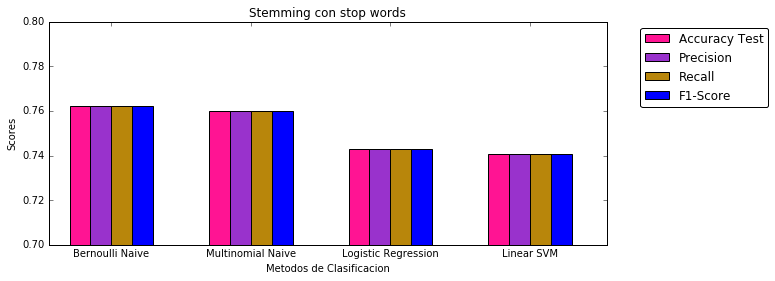

In [39]:
#en esta celda ya están cargados los arreglos por correr la celda anterior
from matplotlib import pyplot as plt
from matplotlib import colors

fig,ax = plt.subplots(figsize=(10, 4), dpi=300)
index = np.arange(4)
bar_width = 0.15
opacity = 1


#accuracy test
plt.bar(index + bar_width, [scores_NAIVE[1],scores_MULTI[1],scores_LOGIT[1],scores_SVM[1]], bar_width,
        alpha=opacity, color='deeppink', label='Accuracy Test')
#Precision
plt.bar(index + 2*bar_width, [scores_NAIVE[2],scores_MULTI[2],scores_LOGIT[2],scores_SVM[2]], bar_width,
        alpha=opacity, color='darkorchid', label='Precision')
#Recall
plt.bar(index + 3*bar_width, [scores_NAIVE[3],scores_MULTI[3],scores_LOGIT[3],scores_SVM[3]], bar_width,
        alpha=opacity, color='darkgoldenrod', label='Recall')
#F1-Score
rects5 = plt.bar(index + 4*bar_width, [scores_NAIVE[4],scores_MULTI[4],scores_LOGIT[4],scores_SVM[4]], bar_width,
        alpha=opacity, color='b', label='F1-Score')

plt.xlabel('Metodos de Clasificacion')
plt.ylabel('Scores')
plt.title('Stemming con stop words')
plt.xticks(index + bar_width*3, ('Bernoulli Naive', 'Multinomial Naive', 'Logistic Regression', 'Linear SVM'))
ax.set_ylim([0.7,0.8])
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2,fancybox=True)

fig.savefig('stemming con stop.png',bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()
%matplotlib inline

Como se pudo observar en las métricas anteriormente, numéricamente las métricas son muy similares, pero al limitar el eje Y entre 0.7 y 0.8, se observa que Bernoulli naive Bayes es mejor que regresión logistica y SVM lineal. Además, se puede observar claramente lo similares que son las métricas para un mismo modelo.